## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution
3. Surface plots

In [68]:
import sys
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting
from pathlib import Path
sys.path.append("../../../analysis/utils")
from utlis import quick_QC


In [69]:
dataset = "qpn"
current_release = "Jan_2024"
FS_version = "v7.3.2"
session = "ses-01"

# /home/nikhil/projects/Parkinsons/qpn/derivatives/freesurfer/v7.3.2/IDP/ses-01

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
tabular_dir = f"{dataset_dir}/releases/{current_release}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{tabular_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# imaging derivatives
FS_dir = f"{dataset_dir}/derivatives/freesurfer/{FS_version}"
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"
FS_DKT_dir = f"{FS_dir}/IDP/{session}/"
DKT_csv = f"{FS_DKT_dir}/aparc.csv"
ASEG_csv = f"{FS_DKT_dir}/aseg.csv"

# UKB encoding of FS fields (DKT + asg)
region_field_dir = "/home/nikhil/projects/Parkinsons/region_field_ids/"
ukbb_dkt_ct_fields = f"{region_field_dir}/UKBB_DKT_CT_Fields.csv"
ukbb_aseg_vol_fields = f"{region_field_dir}/UKBB_ASEG_vol_Fields.csv"

# save dirs
results_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/agg_dfs/"
figs_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/figs/"

# Create dirs for results if they don't exist
Path(f"{results_dir}").mkdir(parents=True, exist_ok=True)
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Colormaps

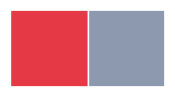

In [99]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### manifest

In [83]:
manifest_cols = ["participant_id", "visit", "session"]
nipoppy_df = pd.read_csv(manifest_csv)
nipoppy_df = nipoppy_df[manifest_cols] 
nipoppy_participants = nipoppy_df["participant_id"].unique()
n_nipoppy_participants = len(nipoppy_participants)
print(f"nipoppy participants: {n_nipoppy_participants}")
nipoppy_df.head()

nipoppy participants: 303


,participant_id,visit,session
0,PD00016,MRI_v1,ses-01
1,PD00020,MRI_v1,ses-01
2,PD00032,MRI_v1,ses-01
3,PD00048,MRI_v1,ses-01
4,PD00119,MRI_v1,ses-01


### Demographic data

Groups:
array(["PD   (Parkinson's Disease)", 'Healthy control',
       'PPS (Parkinson Plus Syndrome)/PPS (Syndrome Parkinson Plus)', nan],
      dtype=object)

In [84]:
group_col = "group_at_screening"

# useful groups:
useful_groups = ["PD", "control"]

demographics_df = pd.read_csv(demographics_csv)
demographics_df = demographics_df[demographics_df["visit"] == "MRI_v1"]

participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")

# replace column values
demographics_df[group_col] = demographics_df[group_col].replace({"PD   (Parkinson's Disease)/Maladie de Parkinson":"PD", 
                                                               "Healthy control/Contrôle": "control",
                                                               "PPS (Parkinson Plus Syndrome)/PPS (Syndrome Parkinson Plus)": "PPS"})

group_counts = demographics_df.groupby([group_col])["participant_id"].count()
print(f"group counts: {group_counts}")

# filter out useful groups
demographics_df = demographics_df[demographics_df[group_col].isin(useful_groups)]
demographics_df = demographics_df.rename(columns={group_col:"group"})

demographics_df.head()

n_participants: 286
group counts: group_at_screening
PD         203
PPS         11
control     67
Name: participant_id, dtype: int64


,participant_id,redcap_event_name,group,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0028,Baseline (Arm 1: C-OPN),PD,M,18,3.5,PD,MRI,v1,60.19,MRI_v1
5,MNI0056,Baseline (Arm 1: C-OPN),PD,M,6,6.5,NaN,MRI,v1,79.24,MRI_v1
9,MNI0058,Baseline (Arm 1: C-OPN),PD,M,11,3.8,PD,MRI,v1,57.43,MRI_v1
13,MNI0068,Baseline (Arm 1: C-OPN),PD,M,12,10.2,PD,MRI,v1,69.30,MRI_v1
16,MNI0079,Baseline (Arm 1: C-OPN),PD,F,20+,6.8,PD,MRI,v1,50.08,MRI_v1


### UKB - DKT - ASEG fields and names

- Replace 'Left-CerebralWhiteMatter', 'Left-Cortex', 'Left-Thalamus-Proper' for FS7.1 

In [144]:
### DKT metadata
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "_" + DKT_fields_df["roi"]

DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

lh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["Field ID"].values.astype("str"))
rh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["Field ID"].values.astype("str"))
rois = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"])

lh_DKT_rois = "lh." + DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["roi"]
rh_DKT_rois = "rh." + DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"]

# hemi specific dict with FS ROI names
lh_DKT_roi_dict = dict(zip(lh_DKT_rois,rois))
rh_DKT_roi_dict = dict(zip(rh_DKT_rois,rois))

# hemi specific dict with UKBB field IDs
lh_DKT_field_roi_dict = dict(zip(lh_DKT_fields,rois))
rh_DKT_field_roi_dict = dict(zip(rh_DKT_fields,rois))


### ASEG metadata
ASEG_fields_df = pd.read_csv(ukbb_aseg_vol_fields)

ASEG_fields_sorted = list(ASEG_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

lh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["Field ID"].values.astype("str"))
rh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Right-"]["Field ID"].values.astype("str"))
global_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["Field ID"].values.astype("str"))

## FS 7 naming peculiarities for global ROIs
FS_global_aseg_vol_renamings = {
'BrainSegNotVentSurf': 'BrainSegNotVent', 
'CC-Anterior':'CC_Anterior', 
'CC-Central': 'CC_Central', 
'CC-Mid-Anterior': 'CC_Mid_Anterior', 
'CC-Mid-Posterior': 'CC_Mid_Posterior', 
'CC-Posterior': 'CC_Posterior', 
'EstimatedTotalIntraCranial': 'EstimatedTotalIntraCranialVol', 
'VentricleChoroid': 'VentricleChoroidVol'
}

ASEG_fields_df["FS7_roi"] = ASEG_fields_df["roi"].copy()
ASEG_fields_df["FS7_roi"] = ASEG_fields_df["FS7_roi"].replace(FS_global_aseg_vol_renamings)

global_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["FS7_roi"])

hemi_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["roi"])

## Unfortunately "CerebralWhiteMatter","Cortex" are still named as "lhxxxx" and "rhxxxx"
## Thalamus-Proper is named as "Thalamus"
atypical_hemi_rois = ["CerebralWhiteMatter","Cortex","Thalamus-Proper"]
lh_atypical_hemi_rois = ["lhCerebralWhiteMatter","lhCortex","Left-Thalamus"]
rh_atypical_hemi_rois = ["rhCerebralWhiteMatter","rhCortex","Right-Thalamus"]

lh_hemi_ASEG_rois = "Left-" + ASEG_fields_df[(ASEG_fields_df["hemi"]=="Left-")]["roi"]
rh_hemi_ASEG_rois = "Right-" + ASEG_fields_df[(ASEG_fields_df["hemi"]=="Right-")]["roi"]

lh_hemi_ASEG_rois.replace({"Left-CerebralWhiteMatter":"lhCerebralWhiteMatter",
                           "Left-Cortex":"lhCortex",
                           "Left-Thalamus-Proper":"Left-Thalamus"},inplace=True)
rh_hemi_ASEG_rois.replace({"Right-CerebralWhiteMatter":"rhCerebralWhiteMatter",
                           "Right-Cortex":"rhCortex",
                           "Right-Thalamus-Proper":"Right-Thalamus"},inplace=True)

lh_hemi_ASEG_roi_dict = dict(zip(lh_hemi_ASEG_rois,hemi_rois))
rh_hemi_ASEG_roi_dict = dict(zip(rh_hemi_ASEG_rois,hemi_rois))

# hemi specific dict
lh_ASEG_field_roi_dict = dict(zip(lh_ASEG_fields,hemi_rois))
rh_ASEG_field_roi_dict = dict(zip(rh_ASEG_fields,hemi_rois))
global_ASEG_field_roi_dict = dict(zip(global_ASEG_fields,global_rois))

ASEG_fields_df.head()

,Unnamed: 0,Field ID,Description,metric,roi,hemi,hemi_ROI,FS7_roi
0,43,26523,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,NaN,3rd-Ventricle,3rd-Ventricle
1,44,26524,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,NaN,4th-Ventricle,4th-Ventricle
2,45,26525,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,NaN,5th-Ventricle,5th-Ventricle
3,46,26564,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Left-Accumbens-area,Accumbens-area
4,47,26595,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Right-Accumbens-area,Accumbens-area


### Read DKT data

In [134]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df["participant_id"] = CT_DKT_df["participant_id"].str.split("-", expand=True)[1]

FS_participants = list(CT_DKT_df["participant_id"].unique())
print(f"n_FS_participants: {len(FS_participants)}")

## Merge with demographics
demo_cols = ["participant_id","age","sex","group"]
CT_DKT_df = pd.merge(CT_DKT_df,demographics_df[demo_cols],on="participant_id",how="left")
CT_DKT_df.head()

n_FS_participants: 287


,participant_id,lh.caudalanteriorcingulate,lh.caudalmiddlefrontal,lh.cuneus,lh.entorhinal,lh.fusiform,lh.inferiorparietal,lh.inferiortemporal,lh.isthmuscingulate,lh.lateraloccipital,...,rh.superiorfrontal,rh.superiorparietal,rh.superiortemporal,rh.supramarginal,rh.transversetemporal,rh.insula,rh.temporalpole,age,sex,group
0,MNI0028,2.495,2.365,1.781,3.372,2.821,2.232,2.785,2.061,1.949,...,2.448,2.025,2.732,2.305,2.302,2.981,NaN,60.19,M,PD
1,MNI0056,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.100,2.075,...,2.445,2.400,2.595,2.364,1.990,2.586,NaN,79.24,M,PD
2,MNI0058,2.597,2.626,1.892,3.349,2.956,2.457,2.774,2.364,2.008,...,2.545,2.352,2.357,2.597,1.975,1.555,NaN,57.43,M,PD
3,MNI0068,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.004,2.000,...,2.274,1.964,2.516,2.232,2.130,2.888,NaN,69.30,M,PD
4,MNI0079,2.418,2.654,1.875,3.616,2.765,2.504,2.734,2.185,2.291,...,2.647,2.298,2.794,2.668,2.296,3.117,NaN,50.08,F,PD


### Filter demographics based on available BIDS data

In [135]:
demographics_df = demographics_df[demographics_df["participant_id"].isin(FS_participants)]
demographics_df.groupby(["group"])["age"].mean(), demographics_df.groupby(["group"])["age"].std()

(group
 PD         65.697186
 control    61.878548
 Name: age, dtype: float64,
 group
 PD          8.918036
 control    11.668423
 Name: age, dtype: float64)

### Split DKT data into left and right hemisphere

In [136]:
save_results = False

demo_cols = ["participant_id","age","sex","group"]

lh_CT_DKT_df = CT_DKT_df[list(lh_DKT_rois) + demo_cols].copy()
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = CT_DKT_df[list(rh_DKT_rois) + demo_cols].copy()
rh_CT_DKT_df["hemi"] = "rh"

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_DKT_roi_dict)
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_DKT_roi_dict)

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

if save_results:
    CT_DKT_df.to_csv(f"{results_dir}/CT_DKT_df.csv")
    
CT_DKT_df.head()

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,participant_id,age,sex,group,hemi
0,2.495,2.365,1.781,3.372,2.821,2.232,2.785,3.230,2.061,1.949,...,2.465,1.987,2.747,2.245,2.042,MNI0028,60.19,M,PD,lh
1,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.612,2.100,2.075,...,2.533,2.464,2.466,2.275,2.057,MNI0056,79.24,M,PD,lh
2,2.597,2.626,1.892,3.349,2.956,2.457,2.774,3.116,2.364,2.008,...,2.726,2.275,3.036,2.474,2.311,MNI0058,57.43,M,PD,lh
3,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.898,2.004,2.000,...,2.344,1.917,2.355,2.089,1.903,MNI0068,69.30,M,PD,lh
4,2.418,2.654,1.875,3.616,2.765,2.504,2.734,3.343,2.185,2.291,...,2.672,2.356,2.806,2.534,2.068,MNI0079,50.08,F,PD,lh


### Quick QC before plots

In [137]:
check_cols = lh_DKT_roi_dict.values()
min_val = 0
max_val = 10
nan_participants, outlier_participants = quick_QC(CT_DKT_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"removing {len(remove_participants)} participants")
CT_DKT_df = CT_DKT_df[~CT_DKT_df["participant_id"].isin(remove_participants)]

found 1 NaNs and 0 outliers
removing 1 participants


### Plot DKT

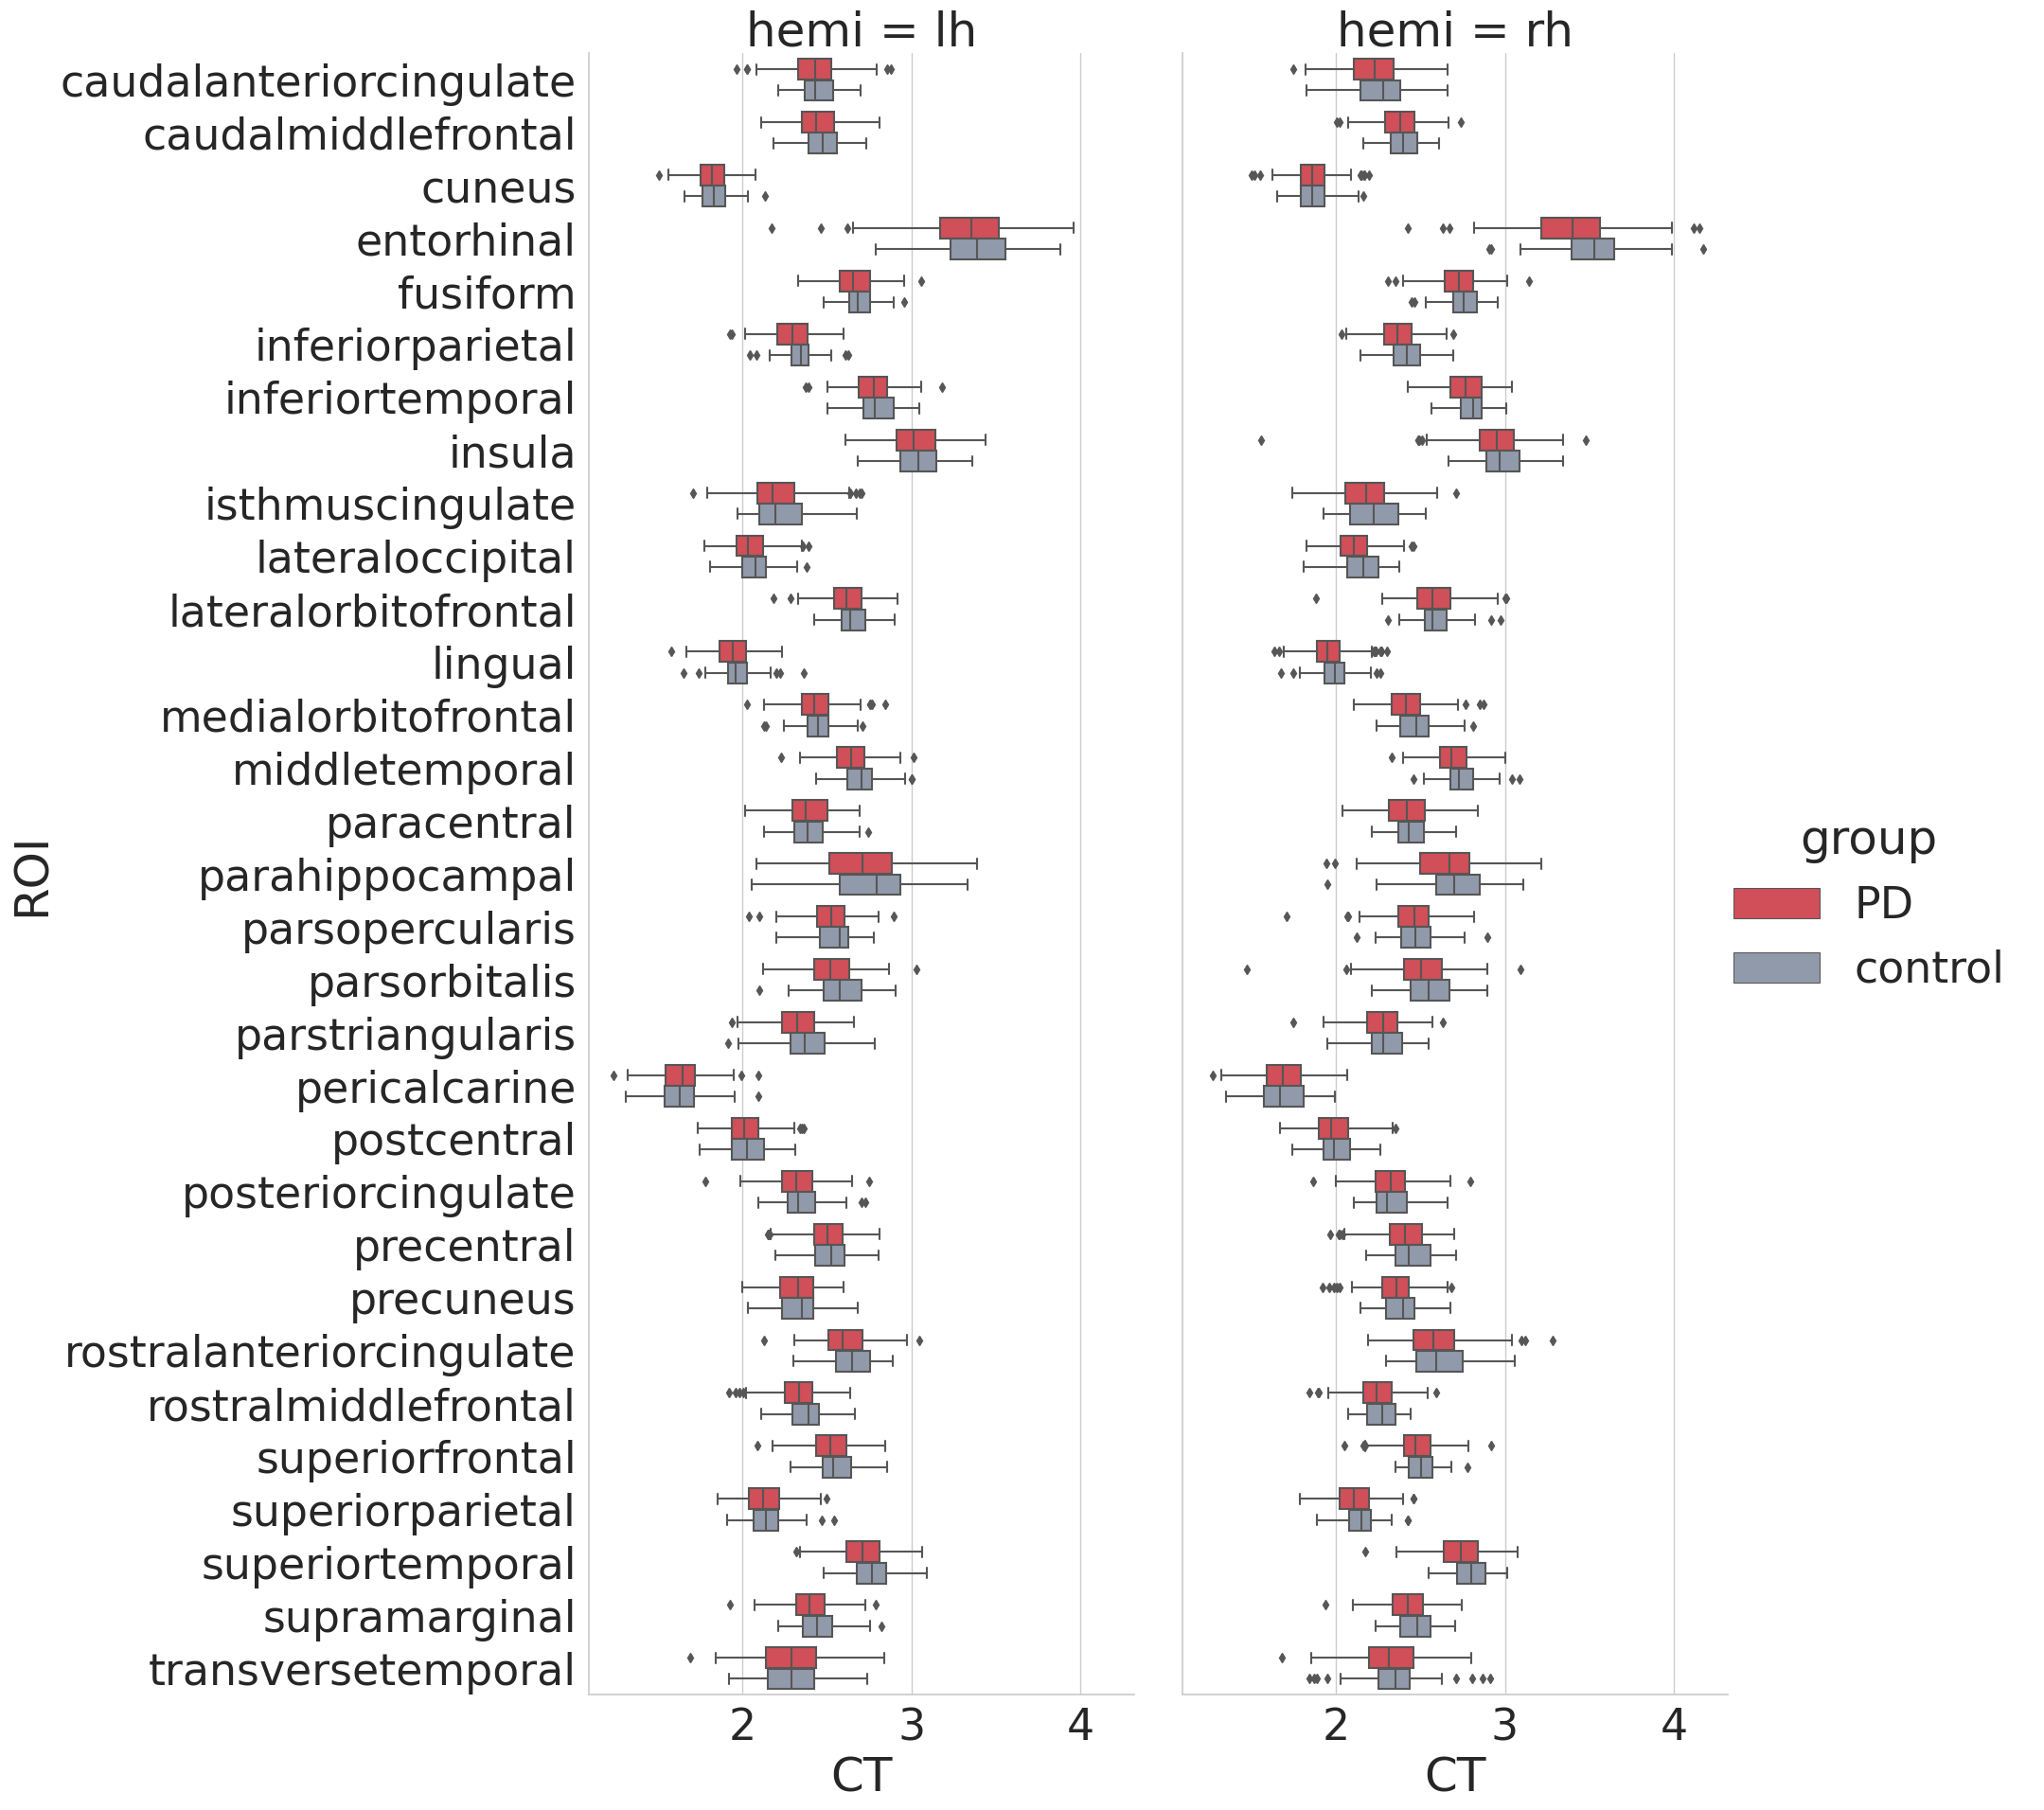

In [138]:
save_fig = False

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set_theme(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="group", col="hemi",kind="box",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Volumetric measures

In [139]:
vol_ASEG_df = pd.read_csv(ASEG_csv)
vol_ASEG_df.head()

,participant_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,TotalGray,SupraTentorial,SupraTentorialNotVent,Mask,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
0,sub-MNI0028,11538.1,228.9,18843.2,54138.4,7875.5,4029.1,4663.7,2000.3,1360.3,...,640926.078926,1121667.0,1094785.0,1561089.0,0.747035,0.919697,3,4,7,1.697395e+06
1,sub-MNI0056,30555.6,1607.7,13703.8,48542.0,6155.8,3487.1,4369.6,1823.3,2976.9,...,619693.412514,1126939.0,1036925.0,1599308.0,0.685579,0.876686,15,11,26,1.824266e+06
2,sub-MNI0058,5535.2,414.3,13783.8,49483.3,8159.6,3600.7,5053.6,2039.0,1429.2,...,647481.631716,1108806.0,1091974.0,1603655.0,0.757695,0.971572,9,35,44,1.650578e+06
3,sub-MNI0068,10275.8,938.8,12266.4,54126.8,6451.4,3012.0,3665.1,1439.1,1348.8,...,581838.746237,932678.0,907166.0,1371644.0,0.709501,0.915154,6,5,11,1.498812e+06
4,sub-MNI0079,4671.2,214.3,16150.4,53101.7,7972.0,3534.6,4085.1,1915.6,952.4,...,626431.995060,1007099.0,994020.0,1447415.0,0.744766,0.941479,6,9,15,1.537383e+06


In [140]:
vol_ASEG_df = pd.read_csv(ASEG_csv)

vol_ASEG_df["participant_id"] = vol_ASEG_df["participant_id"].str.split("-", expand=True)[1]

FS_participants = list(vol_ASEG_df["participant_id"].unique())
print(f"n_FS_participants: {len(FS_participants)}")

vol_ASEG_df = pd.merge(vol_ASEG_df,demographics_df,on="participant_id",how="left")
vol_ASEG_df.head()

n_FS_participants: 287


,participant_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,redcap_event_name,group,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0028,11538.1,228.9,18843.2,54138.4,7875.5,4029.1,4663.7,2000.3,1360.3,...,Baseline (Arm 1: C-OPN),PD,M,18,3.5,PD,MRI,v1,60.19,MRI_v1
1,MNI0056,30555.6,1607.7,13703.8,48542.0,6155.8,3487.1,4369.6,1823.3,2976.9,...,Baseline (Arm 1: C-OPN),PD,M,6,6.5,NaN,MRI,v1,79.24,MRI_v1
2,MNI0058,5535.2,414.3,13783.8,49483.3,8159.6,3600.7,5053.6,2039.0,1429.2,...,Baseline (Arm 1: C-OPN),PD,M,11,3.8,PD,MRI,v1,57.43,MRI_v1
3,MNI0068,10275.8,938.8,12266.4,54126.8,6451.4,3012.0,3665.1,1439.1,1348.8,...,Baseline (Arm 1: C-OPN),PD,M,12,10.2,PD,MRI,v1,69.30,MRI_v1
4,MNI0079,4671.2,214.3,16150.4,53101.7,7972.0,3534.6,4085.1,1915.6,952.4,...,Baseline (Arm 1: C-OPN),PD,F,20+,6.8,PD,MRI,v1,50.08,MRI_v1


### Split bilateral volumetric data into left and right hemisphere

In [142]:
save_results = False

lh_vol_ASEG_df = vol_ASEG_df[list(lh_hemi_ASEG_rois) + demo_cols].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[list(rh_hemi_ASEG_rois) + demo_cols].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[global_rois + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_hemi_ASEG_roi_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_hemi_ASEG_roi_dict)
# global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=global_ASEG_roi_dict)

bilateral_vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

if save_results:
    bilateral_vol_ASEG_df.to_csv(f"{results_dir}/bilateral_vol_ASEG_df.csv")
    global_vol_ASEG_df.to_csv(f"{results_dir}/global_vol_ASEG_df.csv")

bilateral_vol_ASEG_df.head()

KeyError: "['eTIV'] not in index"

### Quick QC before plots

In [128]:
check_cols = lh_hemi_ASEG_roi_dict.values()
min_val = 0
max_val = 3000000
nan_participants, outlier_participants = quick_QC(bilateral_vol_ASEG_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"Bilateral regions: removing {len(remove_participants)} participants")
bilateral_vol_ASEG_df = bilateral_vol_ASEG_df[~bilateral_vol_ASEG_df["participant_id"].isin(remove_participants)]

check_cols = global_rois
nan_participants, outlier_participants = quick_QC(global_vol_ASEG_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"Global regions: removing {len(remove_participants)} participants")
global_vol_ASEG_df = global_vol_ASEG_df[~global_vol_ASEG_df["participant_id"].isin(remove_participants)]




found 0 NaNs and 0 outliers
Bilateral regions: removing 0 participants
found 0 NaNs and 0 outliers
Global regions: removing 0 participants


### Plot ASEG
- hemi 
- global

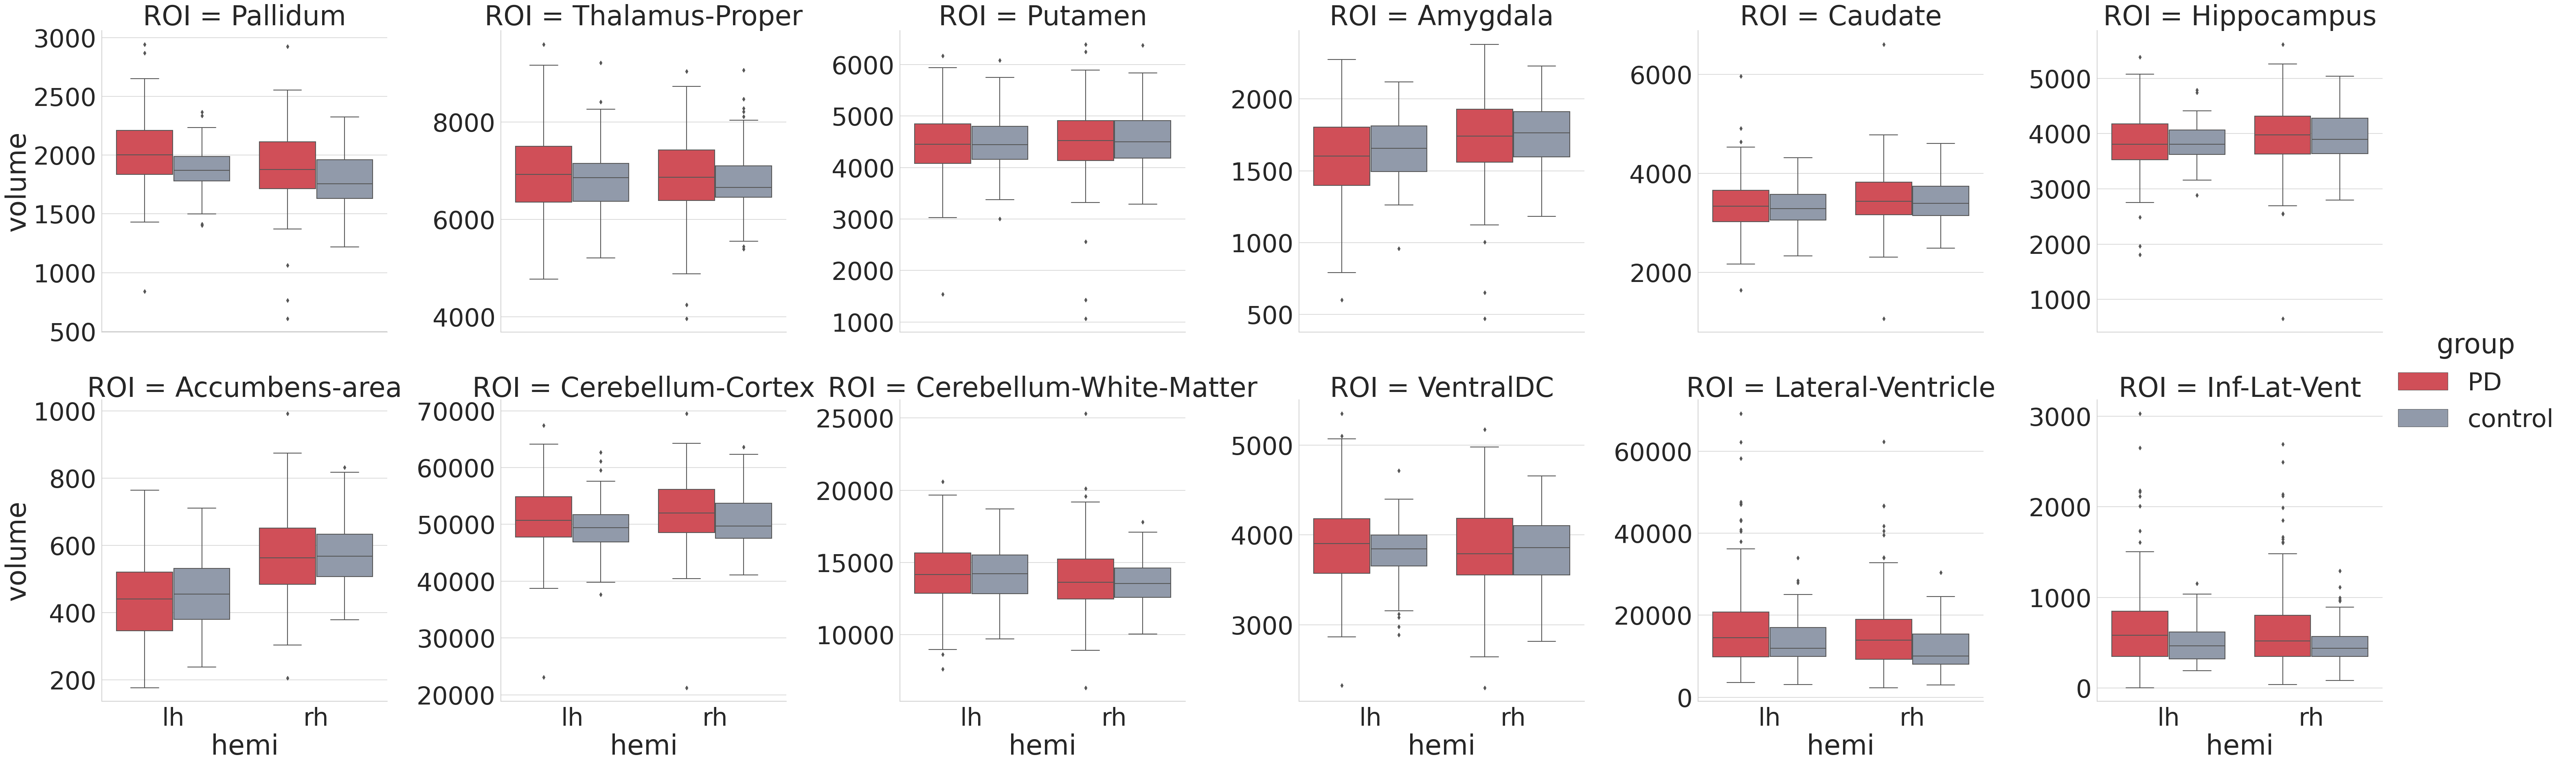

In [129]:
save_fig = False

vol_ASEG_df_melt = bilateral_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_bilateral.png")

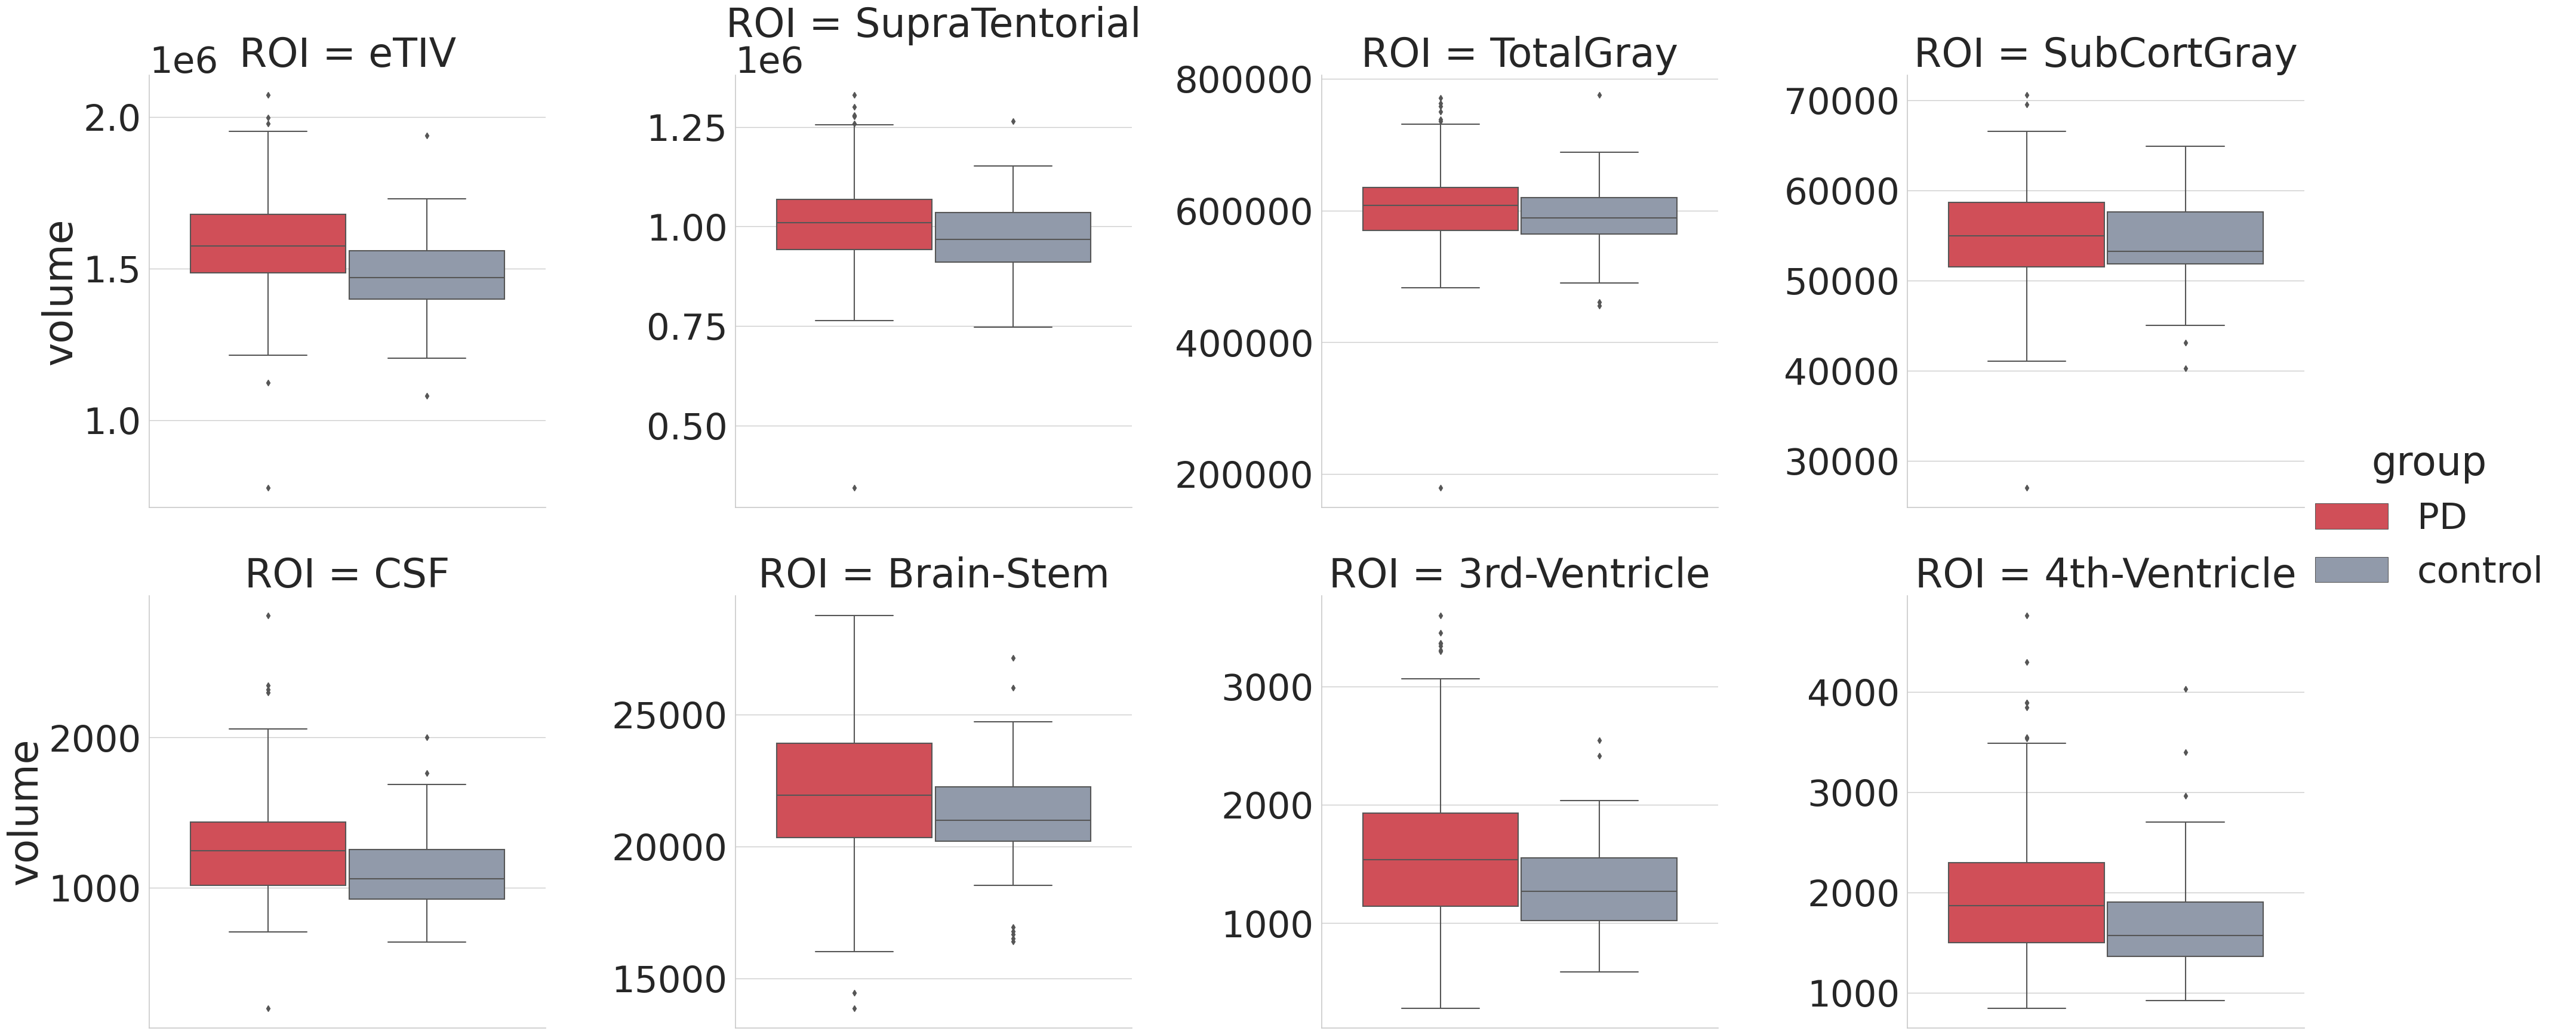

In [148]:
save_fig = False

# Rename global regions for brevity
plot_renaming_dict = {"EstimatedTotalIntraCranialVol":"eTIV"}
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=plot_renaming_dict)

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    g.set_xlabels("")
    g.set_xticklabels("")

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")